p : 0.02
q : 0.5715661997246851
oxygen_half : 0.7393025770482351
OER_0 : 2.2927593269114315


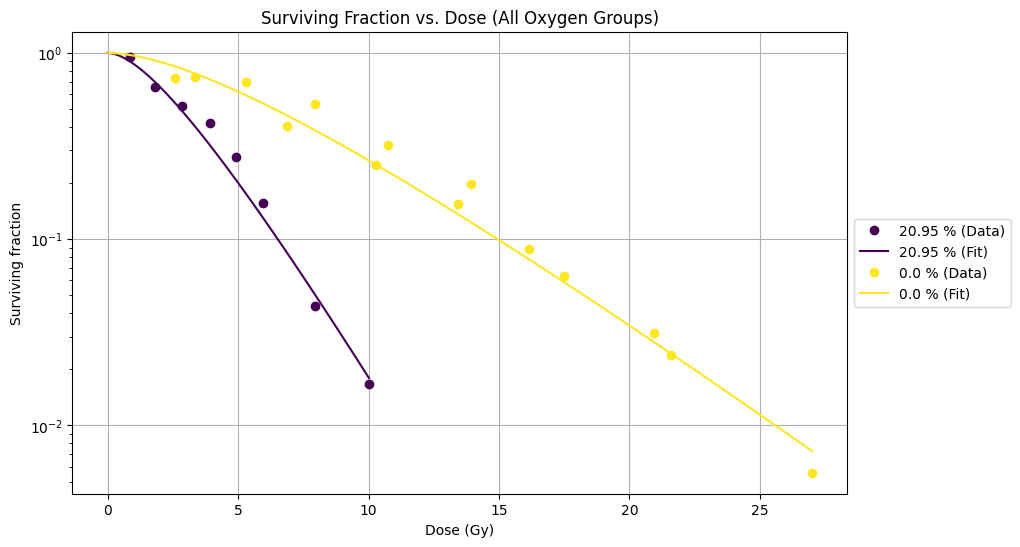

In [21]:
# ==============
# Libraries used
# ==============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from numpy.random import seed, randn, rand
from scipy.optimize import differential_evolution

warnings.filterwarnings('ignore')

# =================
# Defined functions
# =================

def survival_TEM_pred(d, params, oxygen):
    p, q, oxygen_half, OER_0 = params
    OER = (oxygen + oxygen_half) / (oxygen + oxygen_half / OER_0)
    S1 = (1 + (q * d / OER))
    S2 = np.exp(-d * (p + q) / OER)
    return S1 * S2

def survival_TEM(params, x, oxygen):
    p, q, oxygen_half, OER_0 = params
    OER = (oxygen + oxygen_half) / (oxygen + oxygen_half / OER_0)
    S1 = (1 + (q * x / OER))
    S2 = np.exp(-x * (p + q) / OER)
    return S1 * S2

def chi_squared(params, x_list, y_list, oxygen_list):
    chi2 = 0
    for x, y, oxygen in zip(x_list, y_list, oxygen_list):
        predicted = survival_TEM(params, x, oxygen)
        chi2 += np.sum(((y - predicted) / y) ** 2)
    return chi2

# =================
# Data loading and parsing
# =================
file_path = "Influence of acute FIG3.csv"
with open(file_path, "r") as f:
    lines = f.readlines()
data_groups = {}
current_oxygen = None
for line in lines:
    line = line.strip()
    if line.startswith("#"):
        current_oxygen = line.split(",")[1].strip()
        data_groups[current_oxygen] = []
    elif line and current_oxygen is not None:
        values = list(map(float, line.split(",")))
        data_groups[current_oxygen].append(values)
parsed_data = {dose: list(zip(*values)) for dose, values in data_groups.items()}

# Prepare data for optimization
x_list = []
y_list = []
oxygen_list = []
for oxygen, (x, y) in parsed_data.items():
    oxygen = float(oxygen.replace("%", "")) / 100
    #oxygen_ppm = int(oxygen.replace("ppm", ""))  
    #oxygen = oxygen_ppm / 10**6 
    x_list.append(np.array(x))
    y_list.append(np.array(y))
    oxygen_list.append(oxygen)

# =================
# Step 1: Fit p and q using 100% oxygen data
# =================

# Extract 100% oxygen data
oxygen_100_data = parsed_data['20.95%']###########################################
x_100 = np.array(oxygen_100_data[0])
y_100 = np.array(oxygen_100_data[1])

# Define bounds for p and q
p1, p2 = 0.02, 2.0  # Bounds for p
q1, q2 = 0.02, 2.0  # Bounds for q
bounds_pq = np.array([[p1, p2], [q1, q2]])

# Define chi-squared function for p and q only
def chi_squared_pq(params_pq, x, y, oxygen):
    oxygen_half_fixed = 1  # Initial value
    OER_0_fixed = 1  # Initial value
    params = [params_pq[0], params_pq[1], oxygen_half_fixed, OER_0_fixed]
    return chi_squared(params, [x], [y], [oxygen])

# Optimize p and q using differential evolution
result_pq = differential_evolution(
    chi_squared_pq, bounds_pq, args=(x_100, y_100, 1.0),
    strategy='best1bin', maxiter=2000, popsize=25, tol=0.001, mutation=(0.5, 1), recombination=0.7
)

# Extract optimized p and q
p_opt, q_opt = result_pq.x
#print(f'Optimized p and q for 100% oxygen: ')
print(f'p : {p_opt}')
print(f'q : {q_opt}')

# =================
# Step 2: Fit oxygen_half and OER_0 using other oxygen concentrations (excluding 100%)
# =================

# Exclude 100% oxygen data
x_list_filtered = []
y_list_filtered = []
oxygen_list_filtered = []

for x, y, oxygen in zip(x_list, y_list, oxygen_list):
    if oxygen != 0.2095:  ############################################## Exclude 100% oxygen
        x_list_filtered.append(x)
        y_list_filtered.append(y)
        oxygen_list_filtered.append(oxygen)

# Define bounds for oxygen_half and OER_0
oh1, oh2 = 0.00001, 1.0  # Bounds for oxygen_half
oer1, oer2 = 1.0, 5.0  # Bounds for OER_0
bounds_oh_oer = np.array([[oh1, oh2], [oer1, oer2]])

# Define chi-squared function for oxygen_half and OER_0 only
def chi_squared_oh_oer(params_oh_oer, x_list, y_list, oxygen_list, p_fixed, q_fixed):
    params = [p_fixed, q_fixed, params_oh_oer[0], params_oh_oer[1]]
    return chi_squared(params, x_list, y_list, oxygen_list)

# Optimize oxygen_half and OER_0 using differential evolution
result_oh_oer = differential_evolution(
    chi_squared_oh_oer, bounds_oh_oer, args=(x_list_filtered, y_list_filtered, oxygen_list_filtered, p_opt, q_opt),
    strategy='best1bin', maxiter=2000, popsize=25, tol=0.001, mutation=(0.5, 1), recombination=0.7
)
oxygen_half_opt, OER_0_opt = result_oh_oer.x
#print(f'Optimized oxygen_half and OER_0 (excluding 100% oxygen):')
print(f'oxygen_half : {oxygen_half_opt}')
print(f'OER_0 : {OER_0_opt}')

# =================
# Step 3: Plot the results using all optimized parameters
# =================

# Use all optimized parameters
params_opt = [p_opt, q_opt, oxygen_half_opt, OER_0_opt]
params_100 = [p_opt, q_opt, 1, 1]

# Plotting
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(parsed_data)))
for (oxygen, (x, y)), color in zip(parsed_data.items(), colors):
    oxygen = float(oxygen.replace("%", "")) / 100
    dose = np.linspace(0, max(x), 50)
    #oxygen_ppm = int(oxygen.replace("ppm", ""))  
    #oxygen = oxygen_ppm / 10**6 
    dose = np.linspace(0, max(x), 50)
    if oxygen == 0.2095: ######################################################
        SF_pred = survival_TEM_pred(dose, params_100, oxygen) 
        label_data = f'{oxygen*100} % (Data)'
        label_fit = f'{oxygen*100} % (Fit)'
    else:  
        SF_pred = survival_TEM_pred(dose, params_opt, oxygen) 
        label_data = f'{oxygen*100} % (Data)'
        label_fit = f'{oxygen*100} % (Fit)'
    plt.plot(x, y, 'o', color=color, label=label_data)
    plt.plot(dose, SF_pred, '-', color=color, label=label_fit)

# Finalize the plot
plt.yscale('log')
plt.xlabel('Dose (Gy)')
plt.ylabel('Surviving fraction')
plt.title('Surviving Fraction vs. Dose (All Oxygen Groups)')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

DE Optimized p: 0.02
DE Optimized q: 0.23581623912105854
DE performed better.
DE Optimized oxygen_half: 0.3884369599200577, OER_0: 4.680203769275002, Chi^2: 0.20581503195667483
SA Optimized oxygen_half: 0.39527908234004844
SA Optimized  OER_0: 4.722315940694537
DE performed better.


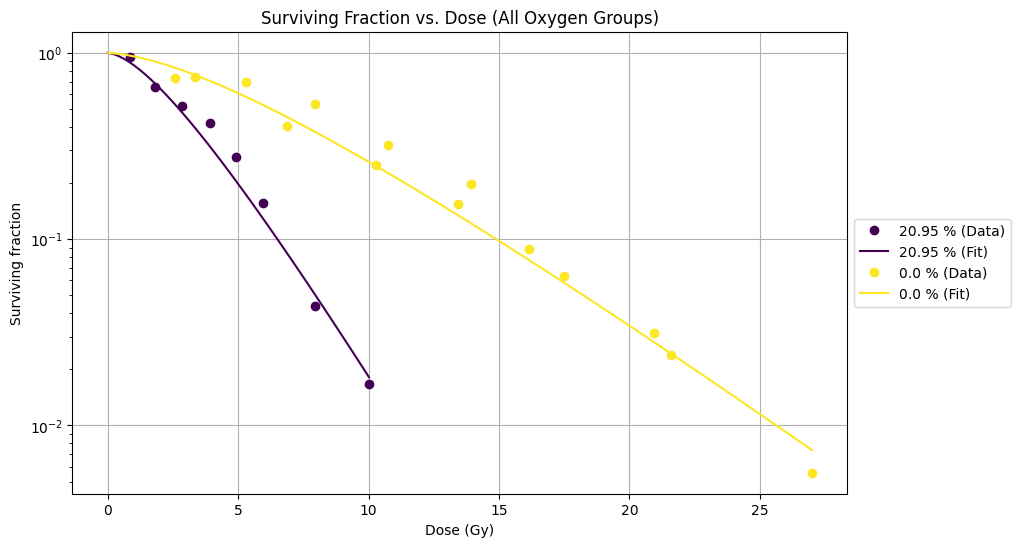

In [22]:
# ==============
# Libraries used
# ==============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from numpy.random import seed, randn, rand
from scipy.optimize import differential_evolution, dual_annealing

warnings.filterwarnings('ignore')

# =================
# Defined functions
# =================

def survival_TEM_pred(d, params, oxygen):
    p, q, oxygen_half, OER_0 = params
    OER = (oxygen  + oxygen_half) / (oxygen *OER_0 + oxygen_half)
    S1 = (1 + (q * d / OER))
    S2 = np.exp(-d * (p + q) / OER)
    return S1 * S2

def survival_TEM(params, x, oxygen):
    p, q, oxygen_half, OER_0 = params
    OER = (oxygen  + oxygen_half) / (oxygen *OER_0 + oxygen_half)
    S1 = (1 + (q * x / OER))
    S2 = np.exp(-x * (p + q) / OER)
    return S1 * S2

def chi_squared(params, x_list, y_list, oxygen_list):
    chi2 = 0
    for x, y, oxygen in zip(x_list, y_list, oxygen_list):
        predicted = survival_TEM(params, x, oxygen)
        chi2 += np.sum(((y - predicted) / y) ** 2)
    return chi2

# =================
# Data loading and parsing
# =================
file_path = "Influence of acute FIG3.csv"
with open(file_path, "r") as f:
    lines = f.readlines()
data_groups = {}
current_oxygen = None
for line in lines:
    line = line.strip()
    if line.startswith("#"):
        current_oxygen = line.split(",")[1].strip()
        data_groups[current_oxygen] = []
    elif line and current_oxygen is not None:
        values = list(map(float, line.split(",")))
        data_groups[current_oxygen].append(values)
parsed_data = {dose: list(zip(*values)) for dose, values in data_groups.items()}

# Prepare data for optimization
x_list = []
y_list = []
oxygen_list = []
for oxygen, (x, y) in parsed_data.items():
    oxygen = float(oxygen.replace("%", "")) / 100
    x_list.append(np.array(x))
    y_list.append(np.array(y))
    oxygen_list.append(oxygen)

# =================
# Step 1: Fit p and q using 100% oxygen data
# =================

# Extract 100% oxygen data
oxygen_100_data = parsed_data['0']
x_100 = np.array(oxygen_100_data[0])
y_100 = np.array(oxygen_100_data[1])

# Define bounds for p and q
p1, p2 = 0.02, 2.0  # Bounds for p
q1, q2 = 0.02, 2.0  # Bounds for q
bounds_pq = np.array([[p1, p2], [q1, q2]])

# Define chi-squared function for p and q only
def chi_squared_pq(params_pq, x, y, oxygen):
    oxygen_half_fixed = 1  # Initial value
    OER_0_fixed = 1  # Initial value
    params = [params_pq[0], params_pq[1], oxygen_half_fixed, OER_0_fixed]
    return chi_squared(params, [x], [y], [oxygen])

# Optimize p and q using differential evolution
result_pq_de = differential_evolution(
    chi_squared_pq, bounds_pq, args=(x_100, y_100, 1.0),
    strategy='best1bin', maxiter=2000, popsize=25, tol=0.001, mutation=(0.5, 1), recombination=0.7
)

# Optimize p and q using simulated annealing
result_pq_sa = dual_annealing(
    chi_squared_pq, bounds_pq, args=(x_100, y_100, 1.0),
    maxiter=1000
)

# Extract optimized p and q from DE
p_opt_de, q_opt_de = result_pq_de.x
chi2_de = chi_squared_pq([p_opt_de, q_opt_de], x_100, y_100, 1.0)
print(f'DE Optimized p: {p_opt_de}')
print(f'DE Optimized q: {q_opt_de}')


# Extract optimized p and q from SA
p_opt_sa, q_opt_sa = result_pq_sa.x
chi2_sa = chi_squared_pq([p_opt_sa, q_opt_sa], x_100, y_100, 1.0)
#print(f'SA Optimized p: {p_opt_sa}, q: {q_opt_sa}, Chi^2: {chi2_sa}')

# Choose the best result
if chi2_de < chi2_sa:
    p_opt, q_opt = p_opt_de, q_opt_de
    print("DE performed better.")
else:
    p_opt, q_opt = p_opt_sa, q_opt_sa
    print("SA performed better.")

# =================
# Step 2: Fit oxygen_half and OER_0 using other oxygen concentrations (excluding 100%)
# =================

# Exclude 100% oxygen data
x_list_filtered = []
y_list_filtered = []
oxygen_list_filtered = []

for x, y, oxygen in zip(x_list, y_list, oxygen_list):
    if oxygen != 0:  # Exclude 20.9% oxygen
        x_list_filtered.append(x)
        y_list_filtered.append(y)
        oxygen_list_filtered.append(oxygen)

# Define bounds for oxygen_half and OER_0
oh1, oh2 = 0.00001, 1.0  # Bounds for oxygen_half
oer1, oer2 = 0.0, 5.0  # Bounds for OER_0
bounds_oh_oer = np.array([[oh1, oh2], [oer1, oer2]])

# Define chi-squared function for oxygen_half and OER_0 only
def chi_squared_oh_oer(params_oh_oer, x_list, y_list, oxygen_list, p_fixed, q_fixed):
    params = [p_fixed, q_fixed, params_oh_oer[0], params_oh_oer[1]]
    return chi_squared(params, x_list, y_list, oxygen_list)

# Optimize oxygen_half and OER_0 using differential evolution
result_oh_oer_de = differential_evolution(
    chi_squared_oh_oer, bounds_oh_oer, args=(x_list_filtered, y_list_filtered, oxygen_list_filtered, p_opt, q_opt),
    strategy='best1bin', maxiter=2000, popsize=25, tol=0.001, mutation=(0.5, 1), recombination=0.7
)

# Optimize oxygen_half and OER_0 using simulated annealing
result_oh_oer_sa = dual_annealing(
    chi_squared_oh_oer, bounds_oh_oer, args=(x_list_filtered, y_list_filtered, oxygen_list_filtered, p_opt, q_opt),
    maxiter=1000
)

# Extract optimized oxygen_half and OER_0 from DE
oxygen_half_opt_de, OER_0_opt_de = result_oh_oer_de.x
chi2_de = chi_squared_oh_oer([oxygen_half_opt_de, OER_0_opt_de], x_list_filtered, y_list_filtered, oxygen_list_filtered, p_opt, q_opt)
print(f'DE Optimized oxygen_half: {oxygen_half_opt_de}, OER_0: {OER_0_opt_de}, Chi^2: {chi2_de}')

# Extract optimized oxygen_half and OER_0 from SA
oxygen_half_opt_sa, OER_0_opt_sa = result_oh_oer_sa.x
chi2_sa = chi_squared_oh_oer([oxygen_half_opt_sa, OER_0_opt_sa], x_list_filtered, y_list_filtered, oxygen_list_filtered, p_opt, q_opt)
print(f'SA Optimized oxygen_half: {oxygen_half_opt_sa}')
print(f'SA Optimized  OER_0: {OER_0_opt_sa}')
# Choose the best result
if chi2_de < chi2_sa:
    oxygen_half_opt, OER_0_opt = oxygen_half_opt_de, OER_0_opt_de
    print("DE performed better.")
else:
    oxygen_half_opt, OER_0_opt = oxygen_half_opt_sa, OER_0_opt_sa
    print("SA performed better.")

# =================
# Step 3: Plot the results using all optimized parameters
# =================

# Use all optimized parameters
params_opt = [p_opt, q_opt, oxygen_half_opt, OER_0_opt]
params_100 = [p_opt, q_opt, 1, 1]

# Plotting
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(parsed_data)))

p_2=0.073
q_2=0.139
oxygen_half_2=0.005
OER_0_2=2.56

for (oxygen, (x, y)), color in zip(parsed_data.items(), colors):
    oxygen = float(oxygen.replace("%", "")) / 100
    dose = np.linspace(0, max(x), 50)
    if oxygen == 0:
        SF_pred = survival_TEM_pred(dose, params_100, oxygen) 
        label_data = f'{oxygen*100} % (Data)'
        label_fit = f'{oxygen*100} % (Fit)'
    else:  
        SF_pred = survival_TEM_pred(dose, params_opt, oxygen) 
        label_data = f'{oxygen*100} % (Data)'
        label_fit = f'{oxygen*100} % (Fit)'
    plt.plot(x, y, 'o', color=color, label=label_data)
    plt.plot(dose, SF_pred, '-', color=color, label=label_fit)

    #params_2 = [p_2, q_2, oxygen_half_2, OER_0_2]
    #SF_pred_2 = survival_TEM_pred(dose, params_2, oxygen)
    #plt.plot(dose, SF_pred_2, '--', color=color, label=f'{oxygen*100} % (p_2, q_2)')

# Finalize the plot
plt.yscale('log')
plt.xlabel('Dose (Gy)')
plt.ylabel('Surviving fraction')
plt.title('Surviving Fraction vs. Dose (All Oxygen Groups)')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

p: 0.02
q: 0.26387428520910733
oxygen_half: 0.00909090909090909
OER_0: 3.393939393939394
chi2: 3.898669856047217


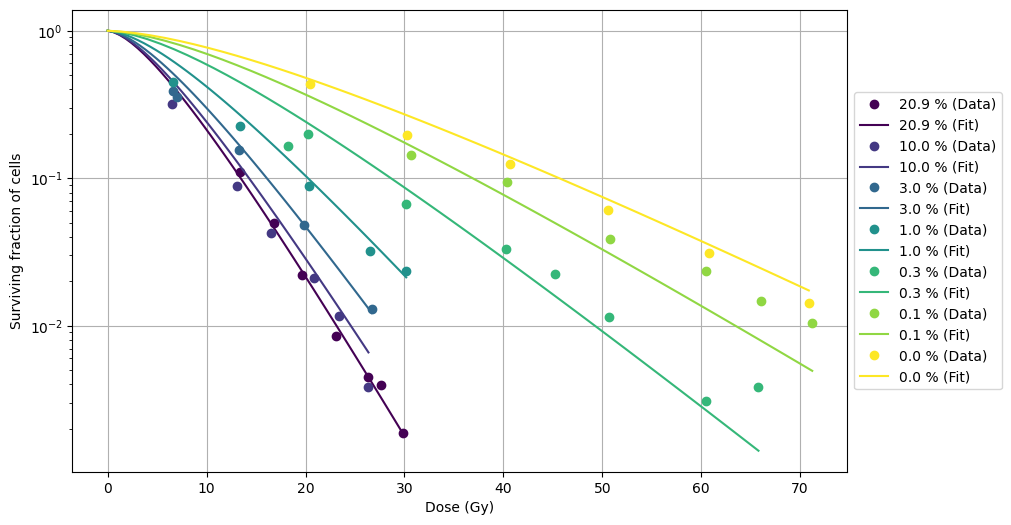

In [2]:
# ==============
# Libraries used
# ==============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy.optimize import differential_evolution
import itertools  # 用于网格搜索

warnings.filterwarnings('ignore')

# ==============
# Defined functions
# ==============

def survival_TEM_pred(d, params, oxygen):
    p, q, oxygen_half, OER_0 = params
    OER = (oxygen + oxygen_half) / (oxygen  + oxygen_half/OER_0)
    S1 = (1 + (q * d / OER ))
    S2 = np.exp(-d * (p + q) / OER )
    return S1 * S2

def survival_TEM(params, x, oxygen):
    p, q, oxygen_half, OER_0 = params
    OER = (oxygen + oxygen_half) / (oxygen  + oxygen_half /OER_0)
    S1 = (1 + (q * x / OER ))
    S2 = np.exp(-x * (p + q) / OER )
    return S1 * S2

def chi_squared(params, x_list, y_list, oxygen_list):
    chi2 = 0
    for x, y, oxygen in zip(x_list, y_list, oxygen_list):
        predicted = survival_TEM(params, x, oxygen)
        chi2 += np.sum(((y - predicted) / y) ** 2)
    return chi2

# ==============
# Data loading and parsing
# ==============
file_path = "Oxygen_Radiosensitisation_at_Low_Dose_Ra_3.37Gyh.csv"
with open(file_path, "r") as f:
    lines = f.readlines()

data_groups = {}
current_oxygen = None
for line in lines:
    line = line.strip()
    if line.startswith("#"):
        current_oxygen = line.split(",")[1].strip()
        data_groups[current_oxygen] = []
    elif line and current_oxygen is not None:
        values = list(map(float, line.split(",")))
        data_groups[current_oxygen].append(values)

parsed_data = {dose: list(zip(*values)) for dose, values in data_groups.items()}

# 数据处理
x_list = []
y_list = []
oxygen_list = []

for oxygen, (x, y) in parsed_data.items():
    #oxygen_ppm = int(oxygen.replace("ppm", ""))  
    #oxygen = oxygen_ppm / 10**6 
    oxygen = float(oxygen.replace("%", "")) / 100  ################################
    x_list.append(np.array(x))
    y_list.append(np.array(y))
    oxygen_list.append(oxygen)

# ==============
# Step 1: 用 DE 优化 p 和 q
# ==============

# 提取 100% 氧气数据
oxygen_100_data = parsed_data['20.9%']  ##########################
x_100 = np.array(oxygen_100_data[0])
y_100 = np.array(oxygen_100_data[1])

# p 和 q 的搜索范围
bounds_pq = np.array([[0.02, 2.0], [0.02, 2.0]])

# 误差计算函数
def chi_squared_pq(params_pq, x, y, oxygen):
    params = [params_pq[0], params_pq[1], 1, 1]  # 先固定 oxygen_half 和 OER_0
    return chi_squared(params, [x], [y], [oxygen])

# 使用 DE 进行优化
result_pq = differential_evolution(
    chi_squared_pq, bounds_pq, args=(x_100, y_100, 1.0),
    strategy='best1bin', maxiter=2000, popsize=25, tol=0.001, mutation=(0.5, 1), recombination=0.7
)

p_opt, q_opt = result_pq.x
print(f'p: {p_opt}')
print(f'q: {q_opt}')

# ==============
# Step 2: 用网格搜索优化 oxygen_half 和 OER_0
# ==============

# 过滤非 100% 氧气数据
x_list_filtered = []
y_list_filtered = []
oxygen_list_filtered = []

for x, y, oxygen in zip(x_list, y_list, oxygen_list):
    if oxygen != 0.209:  ###################################################
        x_list_filtered.append(x)
        y_list_filtered.append(y)
        oxygen_list_filtered.append(oxygen)

# 定义 oxygen_half 和 OER_0 的搜索范围
oxygen_half_values = np.linspace(0.001, 0.01, 100)
OER_0_values = np.linspace(3.0, 4.0, 100)

# 生成网格组合
oh_oer_combinations = list(itertools.product(oxygen_half_values, OER_0_values))

# 进行网格搜索
best_oh_oer = None
min_chi2_oh_oer = float("inf")

for oxygen_half, OER_0 in oh_oer_combinations:
    params = [p_opt, q_opt, oxygen_half, OER_0]
    chi2 = chi_squared(params, x_list_filtered, y_list_filtered, oxygen_list_filtered)
    if chi2 < min_chi2_oh_oer:
        min_chi2_oh_oer = chi2
        best_oh_oer = (oxygen_half, OER_0)

oxygen_half_opt, OER_0_opt = best_oh_oer
print(f'oxygen_half: {oxygen_half_opt}')
print(f'OER_0: {OER_0_opt}')
print(f'chi2: {min_chi2_oh_oer}')

# ==============
# Step 3: 绘制拟合曲线
# ==============

params_opt = [p_opt, q_opt, oxygen_half_opt, OER_0_opt]
params_100 = [p_opt, q_opt, 1, 1]

plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(parsed_data)))

for (oxygen, (x, y)), color in zip(parsed_data.items(), colors):
    #oxygen_ppm = int(oxygen.replace("ppm", ""))  
    #oxygen = oxygen_ppm / 10**6 
    oxygen = float(oxygen.replace("%", "")) / 100################################################
    dose = np.linspace(0, max(x), 50)

    if oxygen == 0.209: ######################################################################
        SF_pred = survival_TEM_pred(dose, params_100, oxygen)
    else:
        SF_pred = survival_TEM_pred(dose, params_opt, oxygen)

    label_data = f'{oxygen*100} % (Data)'
    label_fit = f'{oxygen*100} % (Fit)'

    plt.plot(x, y, 'o', color=color, label=label_data)
    plt.plot(dose, SF_pred, '-', color=color, label=label_fit)

plt.yscale('log')
plt.xlabel('Dose (Gy)')
plt.ylabel('Surviving fraction of cells')
#plt.title('Surviving Fraction vs. Dose (All Oxygen Groups)')
plt.savefig('s_Oxygen_Radiosensitisation_at_Low_Dose_Ra_3.37Gyh.png')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()


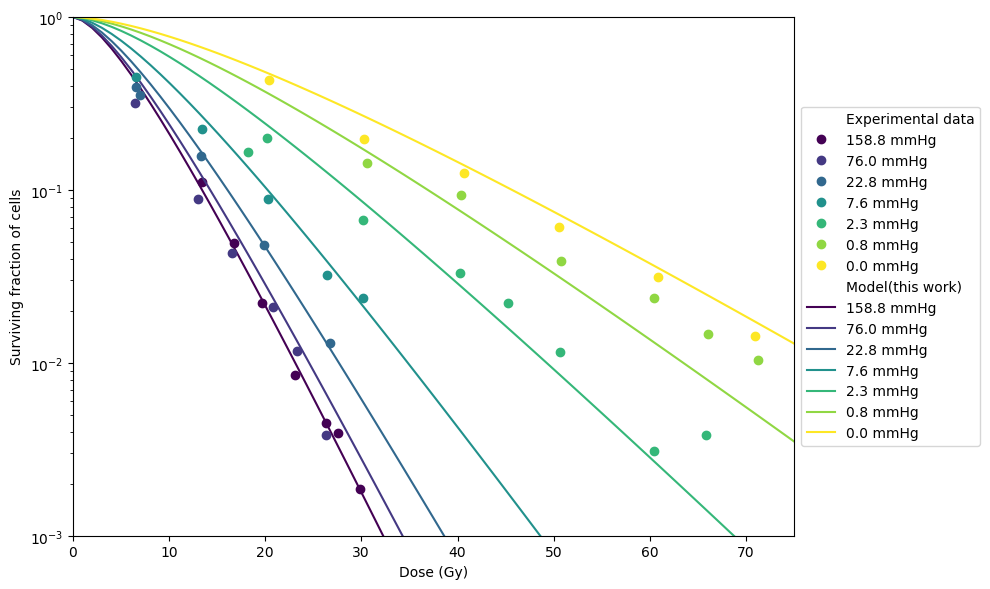

In [18]:
# ==============
# Step 3: 绘制拟合曲线
# ==============

params_opt = [p_opt, q_opt, oxygen_half_opt, OER_0_opt]
params_100 = [p_opt, q_opt, 1, 1]

plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(parsed_data)))
atm_pressure = 760

# 绘制所有数据点和拟合曲线
for (oxygen_percent, (x, y)), color in zip(parsed_data.items(), colors):
    oxygen = float(oxygen_percent.replace("%", "")) / 100
    oxygen_mmhg = oxygen * atm_pressure  # 转换为mmHg
    dose = np.linspace(0, 75, 75)

    if oxygen == 0.209:
        SF_pred = survival_TEM_pred(dose, params_100, oxygen)
    else:
        SF_pred = survival_TEM_pred(dose, params_opt, oxygen)

    # 使用mmHg作为标签
    label_data = f'{oxygen_mmhg:.1f} mmHg'
    label_fit = f'{oxygen_mmhg:.1f} mmHg'

    plt.plot(x, y, 'o', color=color, label=label_data)
    plt.plot(dose, SF_pred, '-', color=color, label=label_fit)

plt.yscale('log')
plt.xlabel('Dose (Gy)')
plt.xlim(0,75)
plt.ylim(1e-3,1)
plt.ylabel('Surviving fraction of cells')

# 获取当前图例句柄和标签
handles, labels = plt.gca().get_legend_handles_labels()

# 分离数据点和拟合曲线的句柄和标签
data_handles = handles[::2]  # 奇数索引是数据点
data_labels = labels[::2]
fit_handles = handles[1::2]  # 偶数索引是拟合曲线
fit_labels = labels[1::2]

# 创建新的图例：先添加"data"标题，然后所有数据点，再添加"fit"标题，然后所有拟合曲线
from matplotlib.patches import Patch

# 创建标题的虚拟句柄
data_title = Patch(color='white', label='Experimental data')
fit_title = Patch(color='white', label='Model(this work)')

# 组合所有句柄和标签
all_handles = [data_title] + data_handles + [fit_title] + fit_handles
all_labels = ['Experimental data'] + data_labels + ['Model(this work)'] + fit_labels

plt.legend(handles=all_handles, labels=all_labels, loc="center left", bbox_to_anchor=(1, 0.5))

#plt.grid(True)
plt.tight_layout()
plt.savefig('s_Oxygen_Radiosensitisation_at_Low_Dose_Ra_3.37Gyh.png')
plt.show()

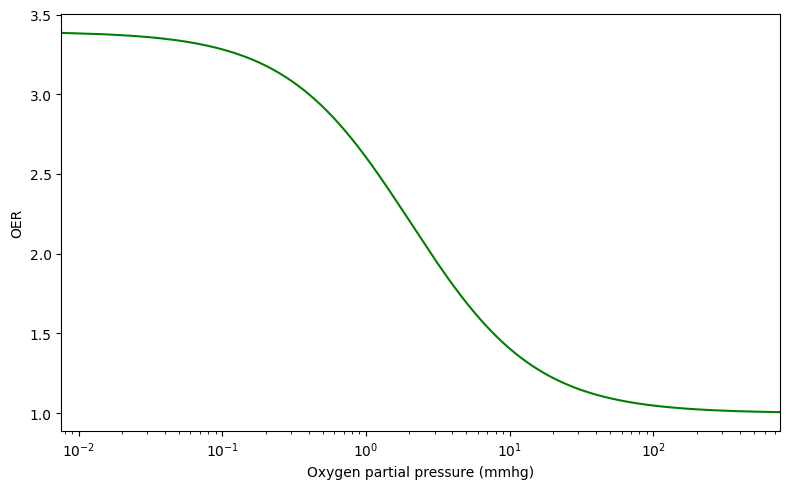

In [22]:
oxygen_half = 1#0.009

def compute_OER(oxygen, oxygen_half, OER_0):
    return (oxygen + oxygen_half) / (oxygen  + oxygen_half/OER_0)
    
oxygen_conc = np.linspace(1e-5, 1, 100000)  # 100个点，log刻度均匀分布
OER_values = [compute_OER(o, oxygen_half_opt, OER_0_opt) for o in oxygen_conc]

# 继续绘图
plt.figure(figsize=(8, 5))
plt.plot(oxygen_conc*760, OER_values, '-', color='g')
plt.xlabel('Oxygen partial pressure (mmhg)')
plt.xscale('log')
plt.ylabel('OER')
plt.xlim(1e-5*760,760)
#plt.ylim(1e-3,1)
#plt.yscale('log')
#plt.title('OER vs. Oxygen Concentration')
plt.savefig('s_Oxygen_Radiosensitisation_at_Low_Dose_OER.png')
#plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
# ==============
# Libraries used
# ==============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy.optimize import differential_evolution
import itertools  # 用于网格搜索

warnings.filterwarnings('ignore')

# ==============
# Defined functions
# ==============

def survival_TEM_pred(d, params, oxygen):
    p, q, oxygen_half, OER_0 = params
    OER = (oxygen + oxygen_half) / (oxygen  + oxygen_half/OER_0)
    S1 = (1 + (q * d / OER ))
    S2 = np.exp(-d * (p + q) / OER )
    return S1 * S2

def survival_TEM(params, x, oxygen):
    p, q, oxygen_half, OER_0 = params
    OER = (oxygen + oxygen_half) / (oxygen  + oxygen_half /OER_0)
    S1 = (1 + (q * x / OER ))
    S2 = np.exp(-x * (p + q) / OER )
    return S1 * S2

def chi_squared(params, x_list, y_list, oxygen_list):
    chi2 = 0
    for x, y, oxygen in zip(x_list, y_list, oxygen_list):
        predicted = survival_TEM(params, x, oxygen)
        chi2 += np.sum(((y - predicted) / y) ** 2)
    return chi2

# ==============
# Data loading and parsing
# ==============
file_path = "Oxygen_Radiosensitisation_at_Low_Dose_Ra_3.37Gyh.csv"
with open(file_path, "r") as f:
    lines = f.readlines()

data_groups = {}
current_oxygen = None
for line in lines:
    line = line.strip()
    if line.startswith("#"):
        current_oxygen = line.split(",")[1].strip()
        data_groups[current_oxygen] = []
    elif line and current_oxygen is not None:
        values = list(map(float, line.split(",")))
        data_groups[current_oxygen].append(values)

parsed_data = {dose: list(zip(*values)) for dose, values in data_groups.items()}

# 数据处理
x_list = []
y_list = []
oxygen_list = []

for oxygen, (x, y) in parsed_data.items():
    oxygen = float(oxygen.replace("%", "")) / 100
    x_list.append(np.array(x))
    y_list.append(np.array(y))
    oxygen_list.append(oxygen)

# ==============
# Step 1: 使用网格搜索同时拟合四个参数 (p, q, oxygen_half, OER_0)
# ==============

# 定义四个参数的搜索范围和网格点数
p_values = np.linspace(0.02, 2.0, 100)          # p 的搜索范围
q_values = np.linspace(0.02, 2.0, 100)          # q 的搜索范围
oxygen_half_values = np.linspace(0.001, 0.1, 100)  # oxygen_half 的搜索范围
OER_0_values = np.linspace(2.5, 4.0, 100)       # OER_0 的搜索范围

# 生成网格组合
param_combinations = list(itertools.product(p_values, q_values, oxygen_half_values, OER_0_values))

# 进行网格搜索
best_params = None
min_chi2 = float("inf")
best_params_history = []  # 记录最佳参数历史

# 添加进度显示
for i, (p, q, oxygen_half, OER_0) in enumerate(param_combinations):

    params = [p, q, oxygen_half, OER_0]
    chi2 = chi_squared(params, x_list, y_list, oxygen_list)
    
    if chi2 < min_chi2:
        min_chi2 = chi2
        best_params = (p, q, oxygen_half, OER_0)
        best_params_history.append((p, q, oxygen_half, OER_0, chi2))

p_opt, q_opt, oxygen_half_opt, OER_0_opt = best_params

print(f'p: {p_opt:.6f}')
print(f'q: {q_opt:.6f}')
print(f'oxygen_half: {oxygen_half_opt:.6f}')
print(f'OER_0: {OER_0_opt:.6f}')
print(f'chi2: {min_chi2:.6f}')

# ==============
# Step 2: 精细网格搜索（在最佳参数附近）
# ==============

p_values_fine = np.linspace(max(0.02, p_opt*0.8), min(2.0, p_opt*1.2), 15)
q_values_fine = np.linspace(max(0.02, q_opt*0.8), min(2.0, q_opt*1.2), 15)
oxygen_half_values_fine = np.linspace(max(0.001, oxygen_half_opt*0.5), min(0.1, oxygen_half_opt*1.5), 15)
OER_0_values_fine = np.linspace(max(3.0, OER_0_opt*0.9), min(4.0, OER_0_opt*1.1), 15)

# 生成精细网格组合
param_combinations_fine = list(itertools.product(p_values_fine, q_values_fine, oxygen_half_values_fine, OER_0_values_fine))

# 精细搜索
for i, (p, q, oxygen_half, OER_0) in enumerate(param_combinations_fine):
    params = [p, q, oxygen_half, OER_0]
    chi2 = chi_squared(params, x_list, y_list, oxygen_list)
    
    if chi2 < min_chi2:
        min_chi2 = chi2
        best_params = (p, q, oxygen_half, OER_0)

p_opt, q_opt, oxygen_half_opt, OER_0_opt = best_params

print(f'p: {p_opt:.6f}')
print(f'q: {q_opt:.6f}')
print(f'oxygen_half: {oxygen_half_opt:.6f}')
print(f'OER_0: {OER_0_opt:.6f}')
print(f'chi2: {min_chi2:.6f}')

# ==============
# Step 3: 绘制拟合曲线
# ==============

params_opt = [p_opt, q_opt, oxygen_half_opt, OER_0_opt]

plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(parsed_data)))

for (oxygen_label, (x, y)), color in zip(parsed_data.items(), colors):
    oxygen_value = float(oxygen_label.replace("%", "")) / 100
    dose = np.linspace(0, max(x) * 1.1, 100)

    # 使用优化后的参数计算拟合曲线
    SF_pred = survival_TEM_pred(dose, params_opt, oxygen_value)

    label_data = f'{oxygen_value*100}% (Data)'
    label_fit = f'{oxygen_value*100}% (Fit)'

    plt.plot(x, y, 'o', color=color, label=label_data, markersize=6)
    plt.plot(dose, SF_pred, '-', color=color, label=label_fit, linewidth=2)

plt.yscale('log')
plt.xlabel('Dose (Gy)', fontsize=12)
plt.ylabel('Surviving fraction of cells', fontsize=12)
plt.grid(True, alpha=0.3)

# 添加参数信息
param_text = (
    f'p = {p_opt:.4f}\n'
    f'q = {q_opt:.4f}\n'
    f'O₂ half = {oxygen_half_opt:.6f}\n'
    f'OER₀ = {OER_0_opt:.4f}\n'
    f'χ² = {min_chi2:.4f}'
)
plt.text(0.02, 0.98, param_text, transform=plt.gca().transAxes, 
         fontsize=10, bbox=dict(boxstyle="round", facecolor="white", alpha=0.9),
         verticalalignment='top')

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

<class 'MemoryError'>: 

In [ ]:
# 定义 OER 函数
def calculate_OER(oxygen, oxygen_half, OER_0):
    return (oxygen + oxygen_half) / (oxygen + oxygen_half / OER_0)

# 创建氧气浓度范围
oxygen_range = np.logspace(-4, 0, 200)
OER_values = calculate_OER(oxygen_range, oxygen_half_opt, OER_0_opt)

plt.figure(figsize=(10, 5))
plt.semilogx(oxygen_range, OER_values, 'b-', linewidth=2)
plt.axhline(y=OER_0_opt, color='r', linestyle='--', label=f'OER₀ = {OER_0_opt:.3f}')
plt.axhline(y=1.0, color='g', linestyle='--', label='OER = 1 (Anoxic)')
plt.xlabel('Oxygen Concentration')
plt.ylabel('OER')
plt.title('Oxygen Enhancement Ratio Curve')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()